In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
import networkx as nx


from world_machine_experiments.shared.save_metrics import load_multiple_metrics, get_values
from world_machine_experiments.toy1d.dimensions import Dimensions
from world_machine.train.stages import StateSaveMethod
from world_machine_experiments.shared.acronyms import format_name

In [2]:
metrics = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_metrics")
parameters = load_multiple_metrics("toy1d_experiment1_configuration_test", "parameters")
train_history = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_train_history")

In [3]:
list(metrics.keys()) == list(parameters.keys()), list(train_history.keys()) == list(metrics.keys())

(True, True)

In [4]:
names = np.array(list(metrics.keys()))
metric_names = ["normal", "use_state", "prediction", "prediction_shallow", "prediction_local"]

In [5]:
parameters_data = []

for name in parameters:
    item = parameters[name]["parameters"]
    item["name"] = name

    for m in metric_names:
        m_1 = m
        m_2 = m
        if m == "prediction_local":
            m_2 = "prediction_shallow"

        for criterion in ["mse", "0.1sdtw"]:
            item[f"{m_1}_{criterion}"] = metrics[name]["means"][m_2][f"state_decoded_{criterion}"]

    item["duration"] = train_history[name]["means"]["duration"].sum()
    
    parameters_data.append(item)

In [6]:
df = pd.DataFrame(parameters_data)

In [7]:
mask = np.ones(len(df), bool)
for metric in metric_names:
    if metric == "prediction_local":
        continue

    mask = np.bitwise_and(mask, np.bitwise_not(df[metric+"_mse"].isna()))

    data = df[f"{metric}_mse"].to_numpy()

    data_mask = np.bitwise_not(np.isnan(data))
    data_mask = np.bitwise_and(data_mask, data<1)
    
    data_max = data[data_mask].mean() + 3*data[data_mask].std()
    
    mask = np.bitwise_and(mask, np.bitwise_not(np.isnan(data)))
    mask = np.bitwise_and(mask, data<data_max)

mask.sum()

3070

In [8]:
for metric in metric_names:
    df[f"normalized_{metric}_mse"] = (df[f"{metric}_mse"] - df[mask][f"{metric}_mse"].mean()) / df[mask][f"{metric}_mse"].std()

In [9]:
df["mask"] = mask

In [10]:
df["SB_1"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == False)
df["SB_2"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == True)

df["SM_1"] = df["state_save_method"] == StateSaveMethod.MEAN.value
df["SM_2"] = df["check_input_masks"] == True

df["AC_1"] = pd.isnull(df["state_activation"])

df["MD_1"] = df["block_configuration"].map(lambda x : np.alltrue(x == [Dimensions.MEASUREMENT.value, Dimensions.STATE_INPUT.value]))

df["NA_1"] = df["noise_config"].map(lambda x: x is not None and "state" in x)
df["NA_2"] = df["noise_config"].map(lambda x: x is not None and "measurement" in x)

#df["ST_1"] = df["recall_stride_past"] == 1
#df["ST_2"] = df["recall_stride_past"] == 3
#df["ST_3"] = df["recall_n_past"] == 1
#df["ST_4"] = df["recall_n_past"] == 5
#df["ST_5"] = df["recall_n_future"] == 1
#df["ST_6"] = df["recall_n_future"] == 5

df["ST_1"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_past"] == 1)
df["ST_2"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_past"] == 5)
df["ST_3"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_past"] == 1)
df["ST_4"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_past"] == 5)

df["ST_5"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_future"] == 1)
df["ST_6"] = np.bitwise_and(df["recall_stride_past"] == 1, df["recall_n_future"] == 5)
df["ST_7"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_future"] == 1)
df["ST_8"] = np.bitwise_and(df["recall_stride_past"] == 3, df["recall_n_future"] == 5)


In [11]:
variables = ["SB_1", "SB_2", "SM_1", "SM_2", "AC_1", "MD_1", "NA_1", "NA_2", "ST_1", "ST_2", "ST_3", "ST_4", "ST_5", "ST_6", "ST_7", "ST_8"]

In [12]:
G = nx.Graph()

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        var_i = variables[i]
        var_j = variables[j]

        if df[df[var_i]][var_j].any():
            G.add_edge(var_i, var_j)

G_c = nx.complement(G)


cliques = list(nx.find_cliques(G_c))

disjoint_groups = []
for c in cliques:
    if len(c)> 1:
        disjoint_groups.append(set(c))

#disjoint_groups = [{"ST_1", "ST_2", "ST_3", "ST_4"}, 
#                  {"ST_5", "ST_6", "ST_7", "ST_8"}, 
#                  {"ST_1", "ST_2", "ST_7", "ST_8"},
#                  {"ST_3", "ST_4", "ST_5", "ST_6"},
#                  {"SB_1", "SB_2"},
#                  ]

In [13]:
def impact_test(df, variable, metric):
    x : pd.DataFrame = df[df[variable] == False]
    y : pd.DataFrame  = df[df[variable] == True]

    disjoint_vars = set()
    for group in disjoint_groups:
        if variable in group:
            disjoint_vars.update(group)

    for var in disjoint_vars:
        x = x[x[var]==False]

    for var in variables:
        if var == variable or var in disjoint_vars:
            continue
    
        x = x.sort_values(by=var, kind="stable")
        y = y.sort_values(by=var, kind="stable")

    x_mask = x["mask"].to_numpy()
    y_mask = y["mask"].to_numpy()
    mask = np.bitwise_and(x_mask, y_mask)
    
    x : np.ndarray = x[metric].to_numpy()
    y : np.ndarray = y[metric].to_numpy()
    
    x = x[mask]
    y = y[mask]
    
    result = wilcoxon(x, y, nan_policy="omit")
    
    diff = (y - x)
    diff = diff[np.bitwise_not(np.isnan(diff))]
    impact = diff.mean()
    impact_std = diff.std()

    return result.pvalue, impact, impact_std, diff 

In [14]:
test_data = []
test_full_data = []

for var in variables:

    for task in metric_names:

        p_value, impact, impact_std, diff = impact_test(df, var, f"{task}_mse")

        item = {"variable":var, "task":format_name(task)}
        item["p_value"] = p_value
        item["impact"] = impact
        item["impact_std"] = impact_std

        test_data.append(item)

        for d in diff:
            item = item.copy()
            item["diff"] = d

            test_full_data.append(item) 

df_test = pd.DataFrame(test_data)
df_test_full = pd.DataFrame(test_full_data)

In [15]:
failed = df_test[df_test["p_value"]>=0.05]

In [16]:
mask_l = df_test_full["variable"] == "SB_1"
mask_l = np.bitwise_and(mask_l, df_test_full["task"] == "prediction_shallow")

In [17]:
metric_names_formatted = []
for m in metric_names:
    metric_names_formatted.append(format_name(m))

In [18]:
uncond_diverge_prob = 1-(mask.sum()/len(mask))
uncond_diverge_prob

diverge_prob = {}
for v in variables:
    prob = 1- (df[df[v]]["mask"].sum()/len(df[df[v]]))

    diverge_prob[v] = prob



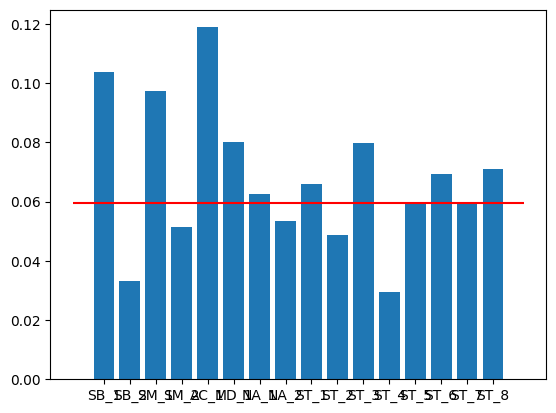

In [19]:
plt.bar(variables, diverge_prob.values())
plt.hlines(uncond_diverge_prob, plt.xlim()[0], plt.xlim()[1], color="red")

In [20]:
for var in variables:
    item = df_test[np.bitwise_and(df_test["variable"] == var,df_test["task"]=="Prediction Shallow")].iloc[0]

    if item["p_value"] < 0.05:
        if np.sign(item["impact"]-item["impact_std"]) != np.sign(item["impact"]+item["impact_std"]):
            print(var, f"{item["impact"]:.5f}+-{item["impact_std"]:.5f}", "AMBIGUOUS IMPACT")
        else:
            mean_duration = df[df[var]].duration.mean()
            print(var, f"{item["impact"]:.5f}+-{item["impact_std"]:.5f}",)
    else:
        print(var, "NO IMPACT")

SB_1 -0.00892+-0.04366 AMBIGUOUS IMPACT
SB_2 -0.01498+-0.04184 AMBIGUOUS IMPACT
SM_1 0.01664+-0.03833 AMBIGUOUS IMPACT
SM_2 NO IMPACT
AC_1 0.03405+-0.05234 AMBIGUOUS IMPACT
MD_1 NO IMPACT
NA_1 0.02002+-0.04808 AMBIGUOUS IMPACT
NA_2 -0.00764+-0.03827 AMBIGUOUS IMPACT
ST_1 0.00486+-0.03975 AMBIGUOUS IMPACT
ST_2 0.01169+-0.04047 AMBIGUOUS IMPACT
ST_3 0.00560+-0.03573 AMBIGUOUS IMPACT
ST_4 0.00383+-0.04406 AMBIGUOUS IMPACT
ST_5 NO IMPACT
ST_6 0.00616+-0.04180 AMBIGUOUS IMPACT
ST_7 NO IMPACT
ST_8 NO IMPACT


In [137]:
def joint_impact_test(df, var1, var2, metric):
    v1v2 = df[np.bitwise_and(df[var1], df[var2])] 
    v1nv2 = df[np.bitwise_and(df[var1], np.bitwise_not(  df[var2]))]
    nv1v2 = df[np.bitwise_and(np.bitwise_not( df[var1]),  df[var2])]
    nv1nv2 = df[np.bitwise_and(np.bitwise_not( df[var1]), np.bitwise_not(  df[var2]))]

    disjoint_vars = set()
    for group in disjoint_groups:
        if var1 in group or var2 in group:
            disjoint_vars.update(group)
    
    for var in [var1, var2]:
        if var in disjoint_vars:
            disjoint_vars.remove(var)

    sets = [v1v2, v1nv2, nv1v2, nv1nv2]

    for var in disjoint_vars:
        for i in range(len(sets)):
            sets[i] = sets[i][sets[i][var]==False]

    for var in variables:
        if var in [var1, var2] or var in disjoint_vars:
            continue

        for i in range(len(sets)):
            sets[i] = sets[i].sort_values(by=var, kind="stable")

    mask = np.ones(len(sets[0]), bool)
    for i in range(4):
        mask = np.bitwise_and(mask, sets[i]["mask"].to_numpy())

    for i in range(4):
        sets[i] = sets[i][metric].to_numpy()
        sets[i] = sets[i][mask]
    
    v1v2 = sets[0]
    v1nv2 = sets[1]
    nv1v2 = sets[2]
    nv1nv2 = sets[3]

    #diff = v1v2-nv1nv2 -> A+B+synergy impact
    #diff -= (v1nv2-nv1nv2) -> -A impact
    #diff -= (nv1v2-nv1nv2) -> -B impact
    diff = v1v2 - v1nv2 - nv1v2 + nv1nv2
    diff = diff[np.bitwise_not(np.isnan(diff))]

    result = wilcoxon(diff, nan_policy="omit")
    
    impact = diff.mean()
    impact_std = diff.std()

    return result.pvalue, impact, impact_std, diff

In [138]:
var1 = "SM_1"
var2 = "NA_1"
metric = "prediction_shallow_mse"

p_value, impact, _, _ = joint_impact_test(df, var1, var2, "prediction_shallow_mse")

In [139]:
p_value, impact, impact_std

(0.016173441006378752, 0.0053495743961045235, 0.0391321858359413)

In [140]:
var1_impact = df_test[np.bitwise_and(df_test["variable"] == var1, df_test["task"]=="Prediction Shallow")]["impact"].iloc[0]
var2_impact = df_test[np.bitwise_and(df_test["variable"] == var2, df_test["task"]=="Prediction Shallow")]["impact"].iloc[0]

var1_impact, var2_impact, var1_impact+var2_impact

(0.016640132879091503, 0.020015150015724115, 0.03665528289481562)

In [141]:
joint_impact = np.zeros((len(variables), len(variables)))
joint_impact_pvalue = np.zeros((len(variables), len(variables)))

for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        var1 = variables[i]
        var2 = variables[j]

        disjoint = False
        for group in disjoint_groups:
            if var1 in group and var2 in group:
                disjoint = True
                break
        
        if disjoint:
            continue

        p_value, impact, _, _ = joint_impact_test(df, var1, var2, "prediction_shallow_mse")

        joint_impact[i,j] = impact
        joint_impact_pvalue[i,j] = p_value

for i, var in enumerate(variables):
    joint_impact[i,i] = df_test[np.bitwise_and(df_test["variable"] == var, df_test["task"]=="Prediction Shallow")]["impact"].iloc[0]
    joint_impact_pvalue[i,i] = df_test[np.bitwise_and(df_test["variable"] == var, df_test["task"]=="Prediction Shallow")]["p_value"].iloc[0]

AB - A - B

A = A -NA

B = B - NB

AB = AB - NANB

AB-A+NA-B+NB-NANB

AB + NA + NB - A - B -NANB

In [142]:
range_limit = np.max(np.abs(joint_impact))

In [143]:
disjoint_groups

disjoint_mask = np.zeros_like(joint_impact)

for dg in disjoint_groups:
    dg = list(dg)
    for i in range(len(dg)):
        for j in range(i+1, len(dg)):
            var_i = variables.index(dg[i])
            var_j = variables.index(dg[j])

            disjoint_mask[var_i, var_j] = 1
            disjoint_mask[var_j, var_i] = 1

In [144]:
for i in range(len(variables)):
    for j in range(len(variables)):
        joint_impact[j,i]=joint_impact[i,j]
        joint_impact_pvalue[j,i] = joint_impact_pvalue[i,j]

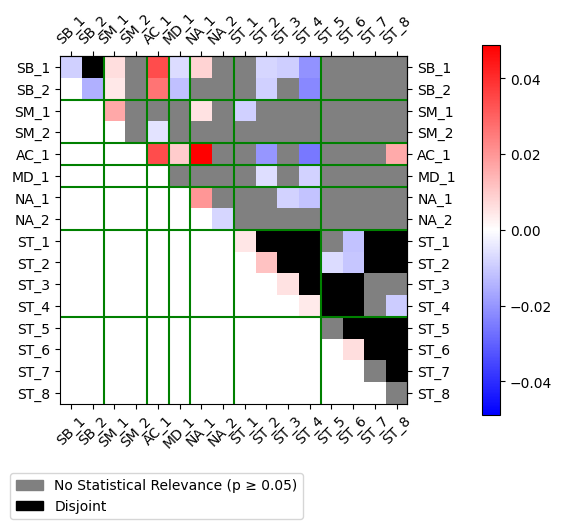

In [145]:

import matplotlib.patches as mpatches

ji_img = plt.imshow(joint_impact,  cmap="bwr", vmin=-range_limit, vmax=range_limit)
plt.colorbar(ji_img, pad=0.15)

plt.imshow(0.5*np.ones_like(joint_impact), alpha=(joint_impact_pvalue>=0.05).astype(np.float32), vmin=0, vmax=1, cmap="gray")
plt.imshow(np.zeros_like(joint_impact), alpha=disjoint_mask, vmin=0, vmax=1, cmap="gray")

pvalue_patch = mpatches.Patch(color='gray', label="No Statistical Relevance (p ≥ 0.05)") 
disjoint_patch = mpatches.Patch(color='black', label="Disjoint")
plt.legend(handles=[pvalue_patch, disjoint_patch], bbox_to_anchor=(0.7, -0.2), borderaxespad=0)

ax = plt.gca()
ax.set_xticks(np.arange(0, len(variables), 1), variables, rotation=45)
ax.set_yticks(np.arange(0, len(variables), 1), variables, rotation=0)
#ax.tick_params(labeltop=True, labelright=True)

ax2 = ax.secondary_yaxis("right")
ax2.set_yticks(np.arange(0, len(variables), 1), variables, rotation=0)

ax2 = ax.secondary_xaxis("top")
ax2.set_xticks(np.arange(0, len(variables), 1), variables, rotation=45)

inf_mask = np.tri(len(variables), len(variables), -1)
plt.imshow(inf_mask, alpha=inf_mask, cmap="gray", vmin=0, vmax=1)

divisor_color="green"
plt.hlines(1.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.hlines(3.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.hlines(4.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.hlines(5.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.hlines(7.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.hlines(11.5, -0.5, len(variables)-0.5, color=divisor_color)

plt.vlines(1.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.vlines(3.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.vlines(4.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.vlines(5.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.vlines(7.5, -0.5, len(variables)-0.5, color=divisor_color)
plt.vlines(11.5, -0.5, len(variables)-0.5, color=divisor_color)


plt.show()

In [30]:
disjoint_groups

[{'ST_3', 'ST_4', 'ST_5', 'ST_6'},
 {'ST_5', 'ST_6', 'ST_7', 'ST_8'},
 {'ST_1', 'ST_2', 'ST_3', 'ST_4'},
 {'ST_1', 'ST_2', 'ST_7', 'ST_8'},
 {'SB_1', 'SB_2'}]

In [31]:
joint_impact[0,4]

-0.0032462042985818354

In [32]:
joint_impact[0,3]

0.0009806968126190945

In [33]:
df[np.bitwise_and(df["ST_8"], df["SB_1"])]

,sequence_length,n_sequence,context_size,batch_size,n_epoch,learning_rate,weight_decay,accumulation_steps,state_dimensions,optimizer_class,...,NA_1,NA_2,ST_1,ST_2,ST_3,ST_4,ST_5,ST_6,ST_7,ST_8
10,1000,10000,200,256,100,0.0005,0.00005,1,[0],torch.optim.adamw.AdamW,...,False,True,False,False,False,True,False,False,False,True
18,1000,10000,200,256,100,0.0005,0.00005,1,[0],torch.optim.adamw.AdamW,...,False,False,False,False,False,True,False,False,False,True
26,1000,10000,200,256,100,0.0005,0.00005,1,[0],torch.optim.adamw.AdamW,...,False,True,False,False,True,False,False,False,False,True
51,1000,10000,200,256,100,0.0005,0.00005,1,[0],torch.optim.adamw.AdamW,...,True,False,False,False,True,False,False,False,False,True
70,1000,10000,200,256,100,0.0005,0.00005,1,[0],torch.optim.adamw.AdamW,...,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185,1000,10000,200,256,100,0.0005,0.00005,1,[0],torch.optim.adamw.AdamW,...,True,True,False,False,True,False,False,False,False,True
3186,1000,10000,200,256,100,0.0005,0.00005,1,[0],torch.optim.adamw.AdamW,...,True,True,False,False,False,True,False,False,False,True
3194,1000,10000,200,256,100,0.0005,0.00005,1,[0],torch.optim.adamw.AdamW,...,False,False,False,False,False,False,False,False,False,True
3242,1000,10000,200,256,100,0.0005,0.00005,1,[0],torch.optim.adamw.AdamW,...,False,False,False,False,True,False,False,False,False,True


In [34]:
var1, var2

('ST_7', 'ST_8')

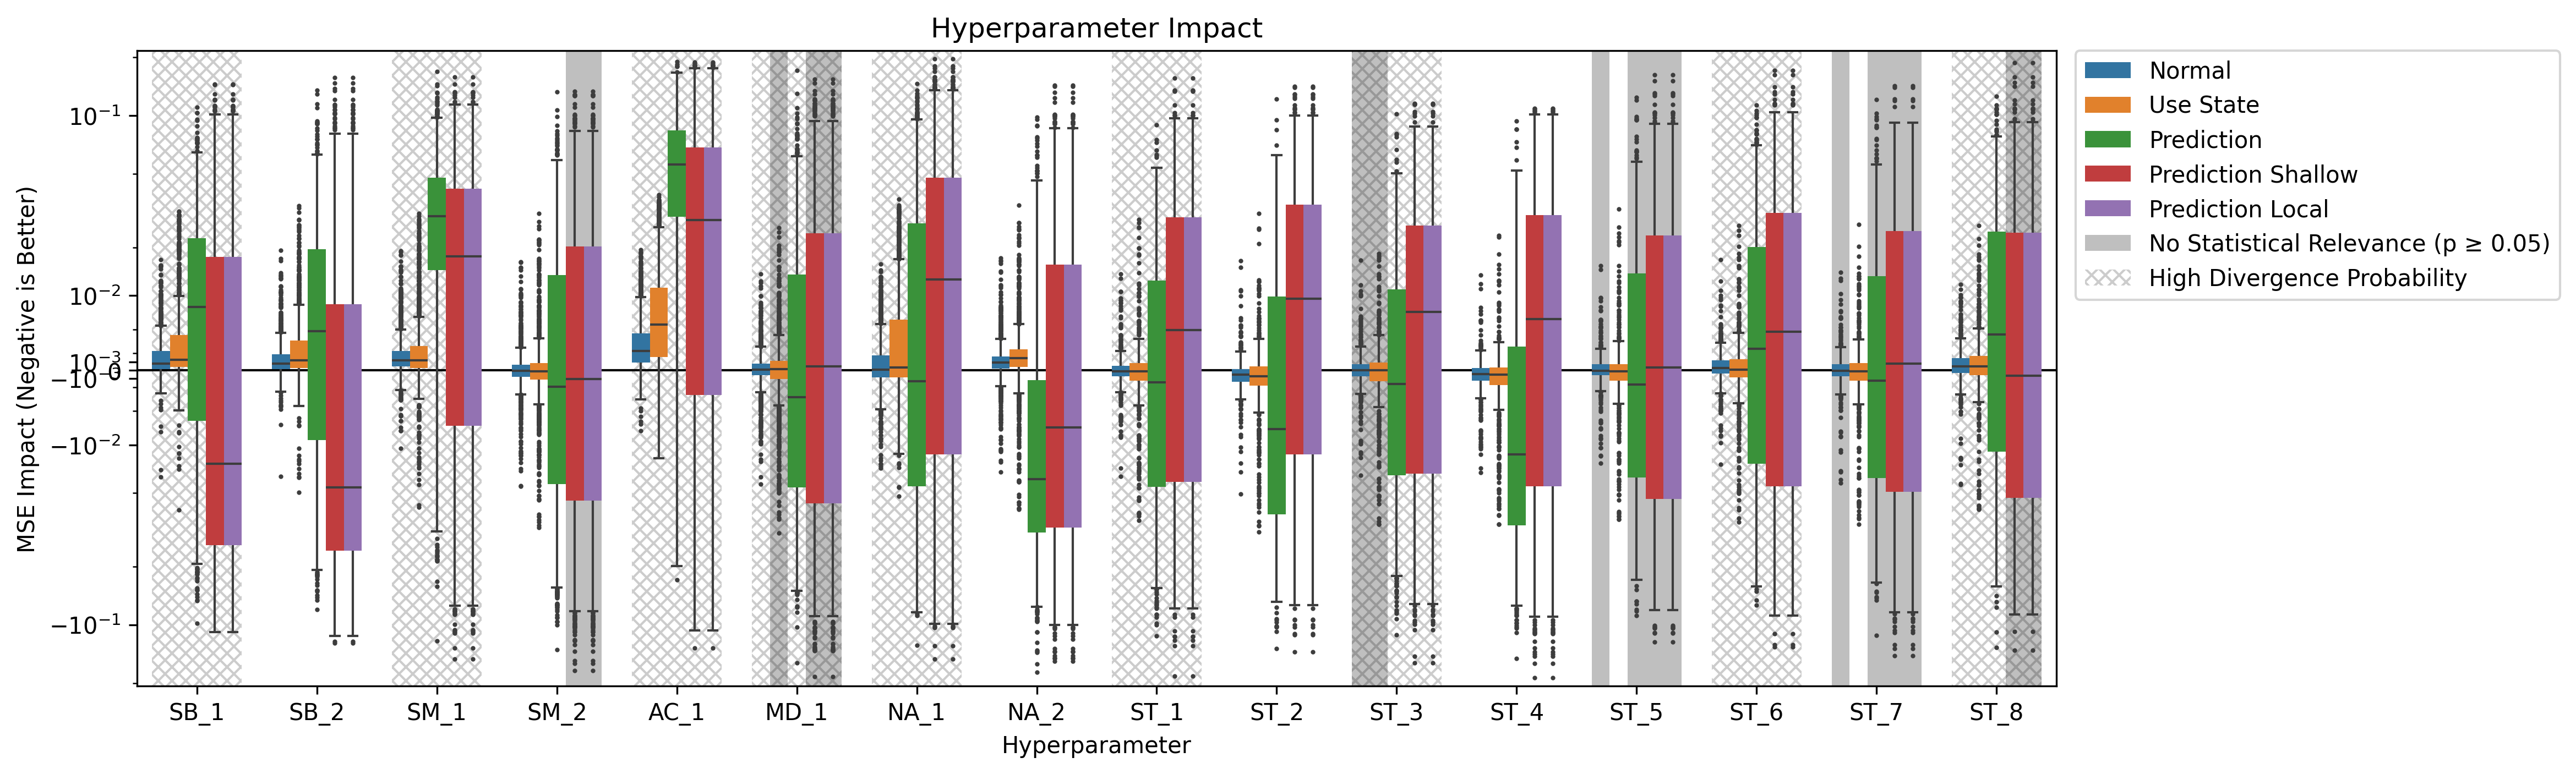

In [35]:
bar_width = 0.15

fig, ax = plt.subplots(dpi=300, figsize=(15, 5))

sns.boxplot(df_test_full, x="variable", y="diff", hue="task", ax=ax, width=5*bar_width, flierprops={"markersize":1},  boxprops={"edgecolor":'none'})
#sns.violinplot(df_test_full, x="variable", y="diff", hue="task", ax=ax, width=5*bar_width, inner=None)
#sns.barplot(df_test_full, x="variable", y="diff", hue="task", ax=ax, width=5*bar_width)#, flierprops={"markersize":1})


xlim = ax.get_xlim()
ylim = ax.get_ylim()

plt.hlines(0, xlim[0], xlim[1], color="black", lw=1, zorder=-1)

for i in range(len(failed)):
    variable = failed.iloc[i]["variable"]
    task = failed.iloc[i]["task"]

    index = variables.index(variable)
    
    task_offset = metric_names_formatted.index(task)
    task_offset -= 2
    task_offset *= bar_width

    index += task_offset


    label=None
    if i == 0:
        label = "No Statistical Relevance (p ≥ 0.05)"
    plt.bar([index, index],  ylim, alpha=0.5, color="gray", width=bar_width, label=label, zorder=-2)

first = True
for variable in variables:
    if diverge_prob[variable] > uncond_diverge_prob:
        label=None
        if first:
            label = "High Divergence Probability"
            first = False

        index = variables.index(variable)
    
        #task_offset = metric_names_formatted.index(task)
        #task_offset -= 2
        #task_offset *= bar_width
#
        #index += task_offset

        plt.bar([index, index], ylim, alpha=0.2, color="black", width=5*bar_width, label=label, zorder=-1, hatch="xxxx", edgecolor="black", linewidth=0, fill=False)


ax.set_xlim(xlim)
ax.set_ylim(ylim)

#ax.set_ylim(-0.06, 0.06)

plt.yscale("asinh", linear_width=0.01)
plt.title("Hyperparameter Impact")
plt.ylabel("MSE Impact (Negative is Better)")
plt.xlabel("Hyperparameter")
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)



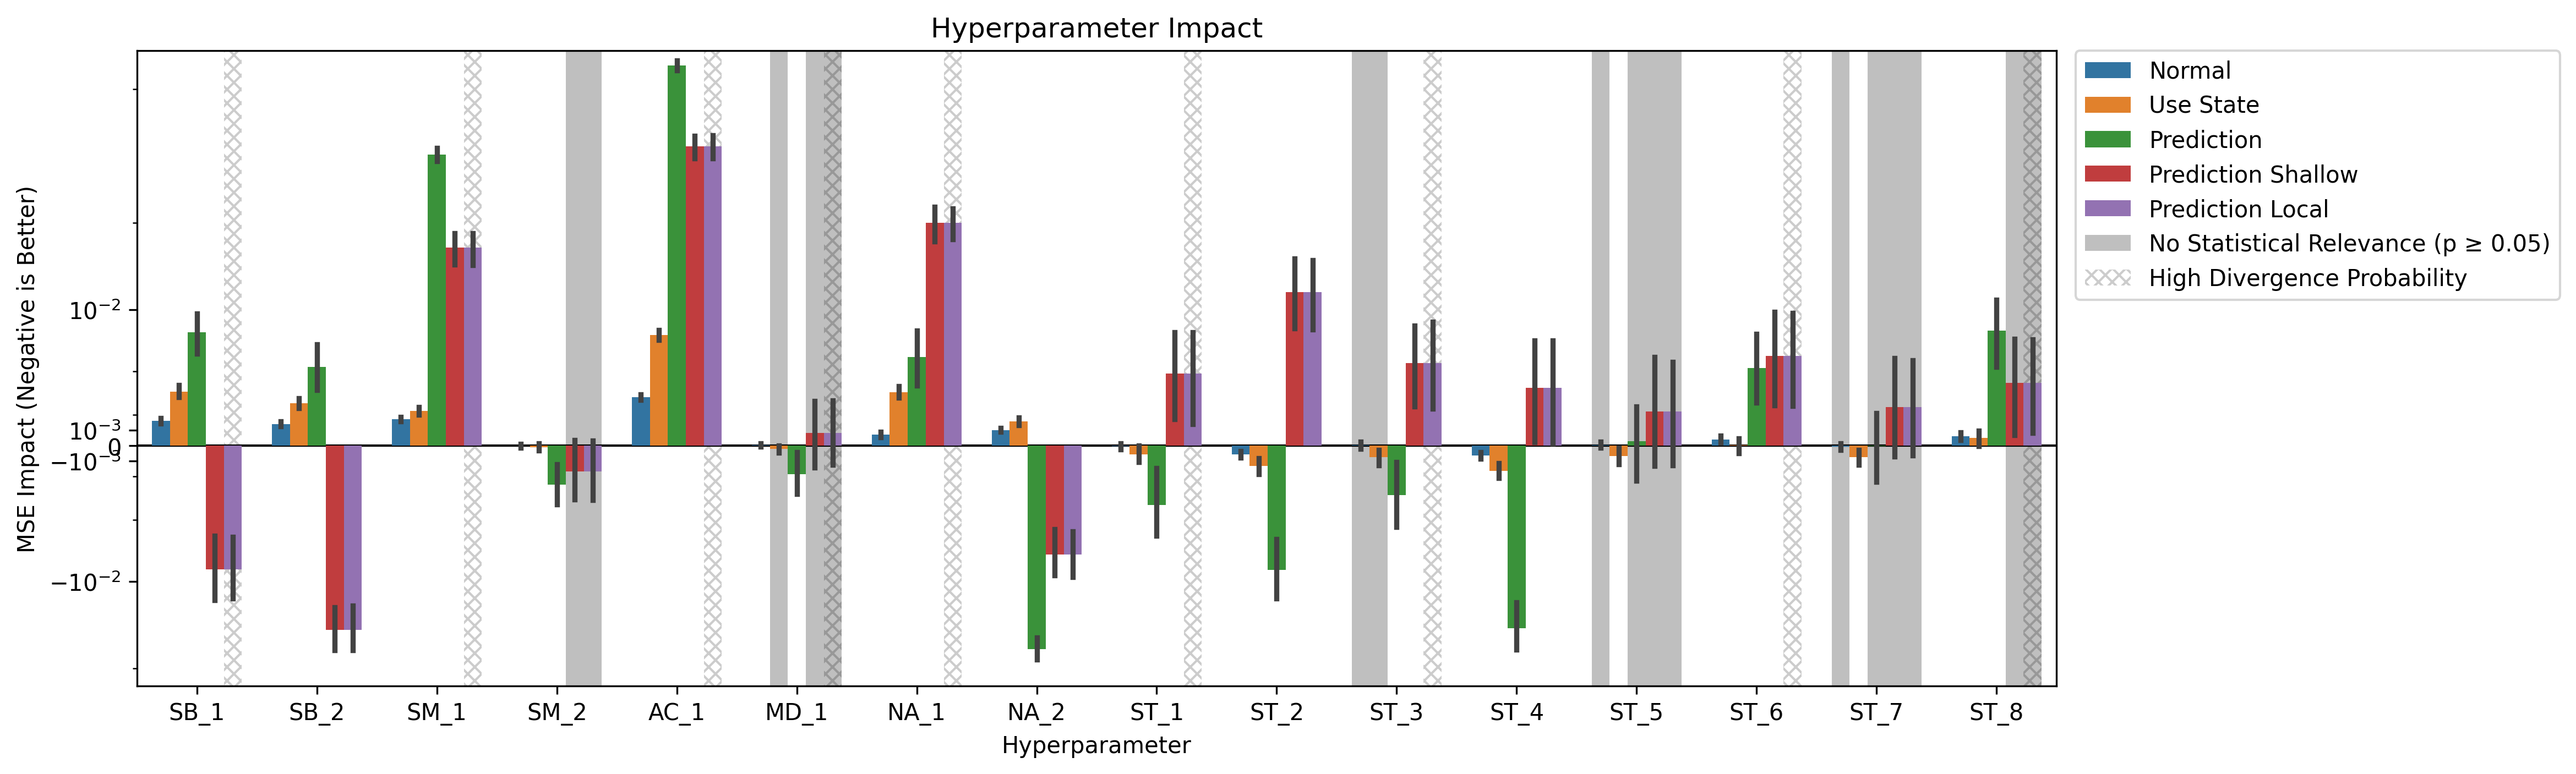

In [36]:
df_test["diverge"] = list(map(lambda var: diverge_prob[var] > uncond_diverge_prob, df_test["variable"]))

In [37]:
usefull = df_test["p_value"] < 0.05
usefull = np.bitwise_and(usefull, np.bitwise_not(df_test["diverge"]))
usefull = np.bitwise_and(usefull, df_test["impact"]<0)

In [38]:
df_tasks = []
for task, task_f in zip(metric_names, metric_names_formatted):

    df_task = df_test[df_test["task"] == task_f]
    df_task = df_task.drop("task", axis=1)
    df_task = df_task.rename(columns={"impact":f"{task}_impact", "p_value":f"{task}_p_value"})

    df_tasks.append(df_task)

In [39]:
df_merged = df_tasks[0]

for i in range(1, len(df_tasks)):
    df_merged = pd.merge(df_merged, df_tasks[i], on=["variable", "diverge"], how="outer")

df_merged

MergeError: Passing 'suffixes' which cause duplicate columns {'impact_std_x'} is not allowed.

In [ ]:
for metric in metric_names:
    df_merged.loc[df_merged[f"{metric}_p_value"] >= 0.05, f"{metric}_impact"] = 0

df_merged

,variable,normal_p_value,normal_impact,diverge,use_state_p_value,use_state_impact,prediction_p_value,prediction_impact,prediction_shallow_p_value,prediction_shallow_impact,prediction_local_p_value,prediction_local_impact
0,AC_1,8.044085e-197,0.003177,True,1.633200e-209,0.007820,1.648560e-226,0.058477,1.847053e-98,0.034046,1.847053e-98,0.034046
1,MD_1,2.147733e-02,0.000033,True,4.380217e-01,0.000000,1.784293e-04,-0.001866,4.475185e-01,0.000000,4.475185e-01,0.000000
2,NA_1,7.150146e-09,0.000714,True,1.976461e-36,0.003528,3.225731e-03,0.006073,2.426552e-43,0.020015,2.426552e-43,0.020015
3,NA_2,9.482794e-103,0.001008,False,3.591104e-94,0.001582,4.037124e-107,-0.017342,2.540638e-15,-0.007640,2.540638e-15,-0.007640
4,SB_1,1.632228e-90,0.001624,True,4.404835e-107,0.003583,1.136456e-22,0.008032,2.137662e-13,-0.008924,2.137662e-13,-0.008924
5,SB_2,7.244094e-89,0.001411,False,5.106828e-102,0.002772,7.809878e-11,0.005323,3.004636e-33,-0.014983,3.004636e-33,-0.014983
6,SM_1,1.574768e-162,0.001731,True,1.035422e-116,0.002285,1.862776e-198,0.032218,9.204662e-58,0.016640,9.204662e-58,0.016640
7,SM_2,4.245768e-02,-0.000014,False,4.731882e-03,-0.000091,9.845432e-04,-0.002560,1.660257e-01,0.000000,1.660257e-01,0.000000
8,ST_1,3.554443e-02,-0.000046,True,1.278549e-02,-0.000553,1.954004e-02,-0.003940,2.427822e-03,0.004862,2.427822e-03,0.004862
9,ST_2,4.489669e-20,-0.000574,False,2.073940e-13,-0.001333,3.390902e-10,-0.008948,3.262734e-11,0.011695,3.262734e-11,0.011695


In [ ]:
usefull = np.bitwise_not(df_merged["diverge"])

usefull_to_any_other = np.zeros(len(df_merged), bool)
for metric in metric_names:
    if metric == "prediction_shallow":
        continue
    usefull_to_any_other = np.bitwise_or(usefull_to_any_other, df_merged[f"{metric}_impact"] < 0)

usefull = np.bitwise_and(usefull,  np.bitwise_or(df_merged["prediction_shallow_impact"] <= 0, np.bitwise_and(df_merged["prediction_shallow_impact"] == 0, usefull_to_any_other)))

In [ ]:
df_merged[usefull]["variable"]

3     NA_2
5     SB_2
7     SM_2
12    ST_5
14    ST_7
Name: variable, dtype: object

In [ ]:
def duration_test(df, variable):
    x : pd.DataFrame = df[df[variable] == False]
    y : pd.DataFrame  = df[df[variable] == True]

    disjoint_vars = set()
    for group in disjoint_groups:
        if variable in group:
            disjoint_vars.update(group)

    for var in disjoint_vars:
        x = x[x[var]==False]

    for var in variables:
        if var == variable or var in disjoint_vars:
            continue

        x = x.sort_values(by=var, kind="stable")
        y = y.sort_values(by=var, kind="stable")

    x_mask = x["mask"].to_numpy()
    y_mask = y["mask"].to_numpy()
    mask = np.bitwise_and(x_mask, y_mask)

    x : np.ndarray = x["duration"].to_numpy()
    y : np.ndarray = y["duration"].to_numpy()

    x = x[mask]
    y = y[mask]

    result = wilcoxon(x, y, nan_policy="omit")

    diff = (y - x)
    impact = diff[np.bitwise_not(np.isnan(diff))].mean()
    std = diff[np.bitwise_not(np.isnan(diff))].std()

    return result.pvalue, impact, std

In [ ]:
for var in variables:
    p_value, duration_impact, duration_impact_std = duration_test(df, var)

    if p_value < 0.05:
        if np.sign(duration_impact-duration_impact_std) != np.sign(duration_impact+duration_impact_std):
            print(var, f"{duration_impact:.2f}+-{df[df[var]].duration.std():.2f}", f"{100*duration_impact/mean_duration:.2f}%", "AMBIGUOUS IMPACT")
        else:
            mean_duration = df[df[var]].duration.mean()
            print(var, f"{duration_impact:.2f}+-{df[df[var]].duration.std():.2f}", f"{100*duration_impact/mean_duration:.2f}%")
    else:
        print(var, "NO IMPACT")

SB_1 -1158.99+-647.02 -31.57%
SB_2 -1337.23+-401.46 -38.06%
SM_1 -215.34+-844.35 -6.13% AMBIGUOUS IMPACT
SM_2 -152.69+-936.80 -4.35% AMBIGUOUS IMPACT
AC_1 NO IMPACT
MD_1 -4.49+-894.74 -0.13% AMBIGUOUS IMPACT
NA_1 NO IMPACT
NA_2 NO IMPACT
ST_1 503.72+-754.94 14.34% AMBIGUOUS IMPACT
ST_2 1036.62+-919.50 23.12%
ST_3 372.94+-683.55 8.32% AMBIGUOUS IMPACT
ST_4 813.84+-837.11 18.15% AMBIGUOUS IMPACT
ST_5 439.22+-728.77 9.79% AMBIGUOUS IMPACT
ST_6 1022.72+-941.64 22.76%
ST_7 477.67+-706.01 10.63% AMBIGUOUS IMPACT
ST_8 996.37+-924.91 22.65%
